<a href="https://colab.research.google.com/github/anirbanmukherjee2709/tsai_end2.0_Session_5/blob/main/Sentiment_Analysis_using_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install necessary packages

In [ ]:
%%shell
pip install google-trans-new

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

import torch, torchtext
from torchtext.legacy import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

import google_trans_new
from google_trans_new import google_translator

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Manual Seed
RANDOM_SEED = 43
torch.manual_seed(RANDOM_SEED)

# Declare Constants
PATH_CSV = '/content/tweets.csv'

NLP_AUG = [
    'random_insertion',
    'random_deletion',
    'random_swap',
    'translate'
]

AUG_COUNT = 6 #arbitrary number can be increased or decreased. But needs to be an positive integer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def getRandomState():
    return np.random.RandomState(RANDOM_SEED)

RANDOM = getRandomState()

# Create translator object
translator = google_translator()
available_langs = list(google_trans_new.LANGUAGES.keys())

Augmentation Functions

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def random_insertion(sentence, n=5): 
    words = remove_stopwords(sentence)
    words, sentence = words.split(), sentence.split() # Code added to tokenize
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        if len(new_synonym) > 0:
            sentence.insert(random.randrange(len(sentence)), random.choice(new_synonym)) 
    return ' '.join(sentence)

def random_deletion(sentence, p=0.5):
    words = sentence.split() # Code added to tokenize
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p, words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return ' '.join([random.choice(words)])
    else:
        return ' '.join(remaining)

def random_swap(sentence, n=5):
    sentence = sentence.split() # Code added to tokenize
    length = range(len(sentence))
    if len(sentence) > 1:
        for _ in range(n):
            idx1, idx2 = random.sample(length, 2)
            sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return ' '.join(sentence)

def translate_and_back(sentence):
    trans_lang = random.choice(available_langs)
    translated = translator.translate(
        translator.translate(sentence, lang_tgt=trans_lang),
        lang_src=trans_lang,
        lang_tgt='en'
    )
    return translated

def augment_dataset(x, y):
    sentence_stack = []
    if AUG_COUNT > 0:
        aug_list = np.random.choice(NLP_AUG, size=AUG_COUNT, p=[0.32, 0.32, 0.32, 0.04])
        # np.random.randint(1, high=len(NLP_AUG) + 1, size=AUG_COUNT, dtype=int)
        
        for num_aug in aug_list:
            if   num_aug == NLP_AUG[0]:
                st = random_insertion(x, random.randint(0, int(len(x)/2)))
                sentence_stack.append((st, y))
            elif num_aug == NLP_AUG[1]:
                sentence_stack.append((random_deletion(x), y))
            elif num_aug == NLP_AUG[2]:
                st = random_swap(x, random.randint(0, int(len(x)/2)))
                sentence_stack.append((st, y))
            elif num_aug == NLP_AUG[3]:
                sentence_stack.append((translate_and_back(x), y))

    return sentence_stack

## Dataset Preview

Your first step to deep learning in NLP. We will be mostly using PyTorch. Just like torchvision, PyTorch provides an official library, torchtext, for handling text-processing pipelines. 

We will be using previous session tweet dataset. Let's just preview the dataset.

In [ ]:
df = pd.read_csv(PATH_CSV)
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [ ]:
df.shape
df.labels.value_counts()


0    931
1    352
2     81
Name: labels, dtype: int64

## Create Augmentation

Create different augmentation for each of the tweets and pass it wil the same label

In [ ]:
df_aug = pd.DataFrame()
for idx in df.index:
    aug_df = pd.DataFrame(augment_dataset(df['tweets'][idx], df['labels'][idx]), columns=['tweets','labels'])
    df_aug = df_aug.append(aug_df)

In [ ]:
# create a single dataset of the augmented and original data
df_new = df.append(df_aug)
# df_new_1 = df_new.sample(frac=1, random_state=RANDOM).reset_index(drop=True)
df_new.reset_index(drop=True,inplace=True)

## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [ ]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [ ]:
fields = [('tweets', Tweet),('labels',Label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [ ]:
example = [data.Example.fromlist([df_new.tweets[i],df_new.labels[i]], fields) for i in range(df_new.shape[0])]

In [ ]:
# Creating dataset
#twitterDataset = data.TabularDataset(path="tweets.csv", format="CSV", fields=fields, skip_header=True)

twitterDataset = data.Dataset(example, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [ ]:
(train, valid) = twitterDataset.split(split_ratio=[0.8, 0.2], random_state=random.seed(RANDOM_SEED))

In [ ]:
(len(train), len(valid))

(7638, 1910)

An example from the dataset:

In [ ]:
vars(train.examples[random.randint(0, df_new.shape[0])])

{'labels': 0,
 'tweets': ['find',
  'along',
  'RT',
  'flummox',
  'generate',
  '@MovieMikeScott',
  ':',
  'fuck',
  'off',
  '#',
  'WhatsRomneyHiding',
  '@BarackObama',
  'GET',
  'along',
  'start',
  'out',
  'obtain',
  'CHA',
  'father',
  'OBAMA',
  'ON',
  '(',
  'Unofficial',
  'on',
  'Obama',
  'Song',
  ')',
  ':',
  'http://t.co/RyG3vgRQ',
  'via',
  'pose',
  '@youtube']}

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:

In [ ]:
Tweet.build_vocab(train)
Label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [ ]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  10327
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 6016), (':', 4437), ('#', 4427), ('.', 4330), (',', 3381), ('the', 3332), ('"', 3175), ('RT', 2916), ('to', 2380), ('?', 2270)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


**Lots of stopwords!!**

Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

In [ ]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [ ]:
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(10327, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 3,340,003 trainable parameters


## Model Training and Evaluation

First define the optimizer and loss functions

In [ ]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [ ]:
N_EPOCHS = 25
best_valid_loss = float('inf')
val_losses = []
train_losses = []

val_accuracy = []
train_accuracy = []

for epoch in range(N_EPOCHS):
     
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)


    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch {epoch+1} | Time Taken: {(time.time() - start_time):.2f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Epoch 1 | Time Taken: 26.23s
	Train Loss: 0.927 | Train Acc: 66.52%
	 Val. Loss: 0.826 |  Val. Acc: 74.05% 

Epoch 2 | Time Taken: 24.69s
	Train Loss: 0.805 | Train Acc: 75.73%
	 Val. Loss: 0.771 |  Val. Acc: 79.07% 

Epoch 3 | Time Taken: 24.71s
	Train Loss: 0.747 | Train Acc: 81.67%
	 Val. Loss: 0.723 |  Val. Acc: 83.89% 

Epoch 4 | Time Taken: 24.73s
	Train Loss: 0.701 | Train Acc: 86.08%
	 Val. Loss: 0.696 |  Val. Acc: 85.99% 

Epoch 5 | Time Taken: 24.79s
	Train Loss: 0.673 | Train Acc: 88.64%
	 Val. Loss: 0.680 |  Val. Acc: 87.58% 

Epoch 6 | Time Taken: 24.59s
	Train Loss: 0.653 | Train Acc: 90.74%
	 Val. Loss: 0.667 |  Val. Acc: 88.88% 

Epoch 7 | Time Taken: 24.62s
	Train Loss: 0.639 | Train Acc: 91.97%
	 Val. Loss: 0.662 |  Val. Acc: 89.20% 

Epoch 8 | Time Taken: 24.70s
	Train Loss: 0.629 | Train Acc: 92.76%
	 Val. Loss: 0.663 |  Val. Acc: 89.04% 

Epoch 9 | Time Taken: 24.74s
	Train Loss: 0.624 | Train Acc: 93.25%
	 Val. Loss: 0.657 |  Val. Acc: 89.48% 

Epoch 10 | Time Tak

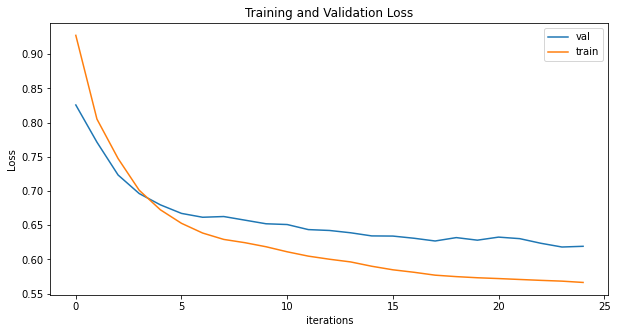

In [ ]:
# Plotting the train and validation loss

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

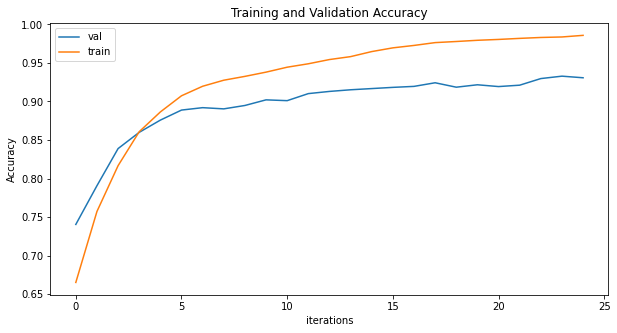

In [ ]:
# Plotting the train and validation Accuracy

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy,label="val")
plt.plot(train_accuracy,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Model Testing

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
inv_categories = {v: k for k,v in categories.items()}

def classify_tweet(tweet):
    
    # categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [ ]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

'Positive'

In [ ]:
df_eval = pd.DataFrame([(df['tweets'][idx], df['labels'][idx], inv_categories[classify_tweet(df['tweets'][idx])]) for idx in df.index], columns=['tweets','labels', 'c_labels'])

In [ ]:
from sklearn.metrics import f1_score
f1_score(df_eval['labels'].values, df_eval['c_labels'].values, average='weighted')

0.9852628048967734

In [ ]:
# not matching
df_incorrect = df_eval[df_eval['labels'] != df_eval['c_labels']]
df_incorrect

,tweets,labels,c_labels
63,RT @LiberalMel: REPUBLICANS WANT TO TAKE AWAY ...,1,0
114,Impossible! RT @Fake_Dispatch: I think we are ...,0,1
146,RT@pslweb Endorsement Of Democrats: A Misuse O...,1,0
218,"Oh, how fun! Another #Obama-created Hashtag #W...",1,0
303,a large number of #GOP women will vote for #O...,2,0
429,@geoff9cow Right! Of course! It's ALWAYS someo...,1,2
526,"RT @GarrettNBCNews: Romney, who earned a combi...",1,0
598,Honey trap: Sexy Russian spy cozied up to Obam...,1,0
599,"Wow.... ""@LauraFlyMe: Proved to be true: Obama...",2,0
602,RealClearPolitics Video - Carney: Obama Not Un...,1,0


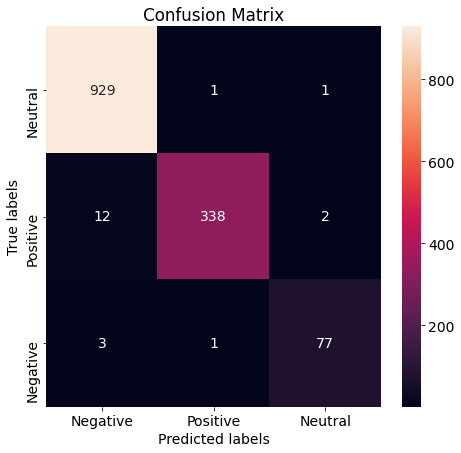

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_eval['labels'].values, df_eval['c_labels'].values)

import seaborn as sns
import matplotlib.pyplot as plt     


font = {'font.size': 14}
plt.rcParams.update(font)
plt.figure(figsize=(7.5,7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(categories.values())); ax.yaxis.set_ticklabels(list(categories.values())[::-1]);

In [ ]:
list(categories.values())[::-1]

['Neutral', 'Positive', 'Negative']